In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import threading
import queue
import os
from typing import TypeVar, Dict, Callable, Tuple, Union, List, Generic, Set, NewType
Fn = Callable

%matplotlib inline
%load_ext line_profiler

In [2]:
def unzip(list_of_tuples):
    unzipped_as_tuples = list(zip(*list_of_tuples))
    return tuple([list(tup) for tup in unzipped_as_tuples])

def sample(it):
    rand = np.random.sample()
    t = 0.0
    if isinstance(it, dict):
        it = it.items()
    else:
        it = enumerate(it)
    for i, f in it:
        t = t + f
        if rand <= t:
            return i

def softmax(x):
    if len(x.shape) == 1:
        exped = np.exp(x - np.max(x))
        return exped / exped.sum()
    else:
        mx = np.max(x, axis=1)
        mx = mx.reshape((1,) + mx.shape).transpose()
        exped = np.exp(x - mx)
        denom = np.sum(exped, axis=1)
        denom = denom.reshape((1,) + denom.shape).transpose()
        return exped / denom

In [3]:
State = TypeVar('State')
Action = NewType('Action', int)
Player = NewType('Player', int)

class Game(Generic[State]):
    def __init__(self):
        pass
        
    def gen_roots(self, num: int) -> Tuple[np.ndarray, np.ndarray]:
        return np.array([self.gen_root() for _ in range(num)])
    def gen_root(self) -> Tuple[State, Player]:
        return self.gen_roots(1)[0]
    
    def do_actions(self, 
                   states: np.ndarray, 
                   actions: np.ndarray, 
                   players: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        lst = list(map(lambda i: self.do_action(states[i], actions[i], players[i], range(players.size))))
        new_states, new_players = unzip(lst)
        return np.array(new_states), np.array(new_players)
    def do_action(self, state: State, action: Action, player: Player) -> Tuple[State, Player]:
        states, players = self.do_actions(np.array([state]), np.array([action]), np.array([player]))
        return states[0], players[0]
    
    def valid_actionses(self, states: np.ndarray, players: np.ndarray) -> np.ndarray:
        return np.array(list(map(lambda i: self.valid_actions(states[i], player[i]), range(players.size))))
    def valid_actions(self, state: State, player: Player) -> np.ndarray:
        return valid_actionses(np.array([state]), np.array([player]))[0]
    
    def check_ends(self, states: np.ndarray, players: np.ndarray) -> np.ndarray:
        return np.array(list(map(lambda i: self.check_end(states[i], players[i]), players.size)))
    def check_end(self, state: State, player: Player) -> np.ndarray:
        return check_ends(np.array([state]), np.array([player]))[0]
        
    @property
    def num_actions(self) -> int:
        raise NotImplemented
    @property
    def num_players(self) -> int:
        raise NotImplemented
        
    def render(self, state: State, player: Player):
        print('Player %d\'s turn:' % player)
        print(state)
        
    def parse(self, s: str):
        return int(s)

In [17]:
# A game player is something that can take a game state and potentially
# return the next move, if it's that player's turn.
GamePlayer = Fn[[State, Player, Action], Action]

class GameAlgorithm(Generic[State]):
    """
    Instantiates GamePlayers.
    """
    
    def __init__(self, game: Game[State]):
        self.game = game
        
    def mk_player(self, players: Set[Player]) -> GamePlayer[State]:
        raise NotImplemented
        
    def __call__(self, players: Set[Player]) -> GamePlayer[State]:
        """
        Simply calls mk_player, provided for convenience.
        """
        return self.mk_player(players)
        
class StatefulGamePlayer(Generic[State]):
    """
    Some GamePlayers need to maintain internal state.
    It should be used to play exactly one game, and it should be given the state on each turn
    of the game regardless of whether or not it's the players turn.
    """
    
    def __init__(self, players: Set[Player]):
        """
        Which players this Player object is playing as.
        """
        self.players = players
    
    def __call__(self, state: State, player: Player, prev_act: Action) -> Action:
        """
        Should be called every turn, regardless of whether it is the player's turn.
        Returns the player's move if it's their turn, otherwise returns None.
        """
        if player in self.players:
            return self._take_turn(state, player, prev_act)
        else:
            self._watch_turn(state, player, prev_act)
            return None
    
    def _take_turn(self, state: State, player: Player, prev_act: Action) -> Action:
        """
        Select the best move.
        """
        raise NotImplemented
    
    def _watch_turn(self, state: State, player: Player, prev_act: Action):
        """
        Keep the player's internal state up to date with the game state.
        Unnecessary if the player has no internal state.
        """
        pass

# note GameAlgorithm.mk_player has type MkPlayer
MkPlayer = Fn[[Set[Player]], GamePlayer[State]]
        
def play_game(game: Game[State], mk_players: List[Tuple[Set[Player], MkPlayer]]):
    player_objs = [ mk_player(players) for players, mk_player in mk_players ]
    players_for, _ = unzip(mk_players)
    players = { p: player for ps, player in zip(players_for, player_objs) for p in ps }
    cur_action = None
    cur_state, cur_player = game.gen_root()
    cur_ends = game.check_end(cur_state, cur_player)
    while not np.any(cur_ends):
        cur_action = players[cur_player](cur_state, cur_player, cur_action)
        cur_state, cur_player = game.do_action(cur_state, cur_action, cur_player)
        cur_ends = game.check_end(cur_state, cur_player)
    return cur_state, cur_ends, player_objs

class UserAlgorithm(GameAlgorithm[State]):
    def __init__(self, game: Game[State]):
        self.game = game
        
    def mk_player(self, players: Set[Player]):
        def take_turn(state: State, player: Player, prev_act: Action) -> Action:
            if player not in players:
                return None
            
            self.game.render(state, player)
            ret = input('What is your move? ')
            while True:
                try:
                    ret = self.game.parse(ret)
                except ValueError:
                    ret = input('What is your move? ')
                else:
                    return ret
                
        return take_turn

In [18]:
TTTState = Tuple[np.ndarray, int]

class TTT(Game[TTTState]):
    _board_shape = (9,)
    num_actions = 9
    num_players = 2
    
    def __init__(self):
        super().__init__()
        
    def gen_root(self) -> Tuple[TTTState, Player]:
        return np.zeros(TTT._board_shape, dtype=np.int), 1

    def do_action(self, s: TTTState, a: Action, p: Player) -> Tuple[TTTState, Player]:
        new_board = np.copy(s)
        new_board[a] = -1 + 2 * p
        return (new_board, 1 - p)

    def valid_actions(self, board: TTTState, _: Player) -> np.ndarray:
        return board == 0

    _end_idx = sum([[3 * i, 3 * i + 1, 3 * i + 2, i, i + 3, i + 6 ] for i in range(3)], [])
    _end_idx = np.array(_end_idx + [2, 4, 6, 0, 4, 8])
    _inv_end_idx = np.array(sum([[3 * i, i] for i in range(3)], []) + [2, 0])
    def check_end(self, board: TTTState, player: Player) -> Player:
        ret = np.zeros(2, dtype=np.bool)
        z = np.flatnonzero(np.abs(np.sum(board[TTT._end_idx].reshape(8, 3), axis=1)) == 3)
        if z.size:
            ret[(board[TTT._inv_end_idx[z[0]]] + 1) // 2] = True
        elif np.all(board):
            ret[:] = True
        return ret
    
    ch = {-1: 'o', 0: ' ', 1: 'x'}
    def render(self, state: State, player: Player):
        for i in range(3):
            if i != 0:
                print('-----')
            for j in range(3):
                if j != 0:
                    print('|', end='')
                print(TTT.ch[state[3 * i + j]], end='')
            print('')
        print('%s\' turn' % ('x' if player == 1 else 'o'))
        
    def parse(self, s: str):
        try:
            x, y = s.split()
            res = 3 * (int(x) - 1) + int(y) - 1
        except:
            raise ValueError
        return res
                
    
ttt = TTT()

In [19]:
class Evaluator(Generic[State]):
    def __init__(self):
        pass
    
    def eval_states(states: np.ndarray, players: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        pass
    
    def eval_state(state: State, player: Player) -> Tuple[np.ndarray, np.ndarray]:
        pass
    
class EvaluatorFromFn(Evaluator[State]):
    def __init__(self, fn, plural=False):
        if plural:
            self.eval_states = fn
        else:
            self.eval_state = fn

In [51]:
c_puct = 1.0
dirichlet_eps = 0.25
dirichlet_alpha = 0.3

class MCTSNode(Generic[State]):
    def __init__(self, state: State):
        self.state = state
        
    @property
    def terminal(self):
        raise NotImplemented

class InternalMCTSNode(MCTSNode[State]):
    terminal = False
    
    def __init__(self, state: State, probs: np.ndarray, player: Player) -> None:
        super().__init__(state)
        self.player = player
        
        self.actions = np.flatnonzero(probs)
        self.inv_actions = np.empty_like(probs, dtype=np.int)
        self.inv_actions[self.actions] = np.arange(self.actions.size)
        
        self.N: np.ndarray = np.zeros_like(self.actions, dtype=np.int)
        self.W: np.ndarray = np.zeros_like(self.actions, dtype=np.float)
        self.Q: np.ndarray = np.zeros_like(self.actions, dtype=np.float)
        self.P: np.ndarray = probs[self.actions]
        
        self.total_visits: int = 1
        self.children: List[MCTSNode] = [None] * probs.size
            
    def select_action(self) -> Action:
        if not self.actions.size:
            return None
        
        root_total = math.sqrt(self.total_visits)
        
        selection_priorities = self.Q + c_puct * root_total * self.P / (1 + self.N)
        return self.actions[np.argmax(selection_priorities)]
    
    def backup(self, a, vs):
        self.total_visits = self.total_visits + 1
        idx = self.inv_actions[a]
        self.N[idx] = self.N[idx] + 1
        self.W[idx] = self.W[idx] + vs[self.player]
        self.Q[idx] = self.W[idx] / self.N[idx]
    
    def probs(self, temp) -> np.ndarray:
        if temp == 0.0:
            ret = np.zeros_like(self.inv_actions)
            ret[self.actions[np.argmax(self.N)]] = 1.0
            return ret
        exps = self.N ** (1.0 / temp)
        ret = np.zeros_like(self.inv_actions, dtype=np.float)
        ret[self.actions] = exps / np.sum(exps)
        return ret
    
class LeafMCTSNode(MCTSNode[State]):
    terminal = True
    
    def __init__(self, state: State, values: np.ndarray):
        super().__init__(state)
        self.values = values

class MCTSAlgorithm(GameAlgorithm[State]):
    def __init__(self, 
                 game: Game[State], 
                 evaluator: Evaluator[State], 
                 search_size: int,
                 temp: float = 0.0):
        self.game = game
        self.evaluator = evaluator
        self.search_size = search_size
        self.temp = temp
        
    def mk_player(self, players: Set[Player]) -> GamePlayer[State]:
        return MCTSPlayer(self, players)
        
    def _do_search(self, node):
        for _ in range(self.search_size):
            cur_node = node
            history: List[Tuple[MCTSNode, Action]] = []

            while cur_node and not cur_node.terminal:
                action = cur_node.select_action()
                history.append((cur_node, action))
                cur_node = cur_node.children[action]

            rewards: float
            if cur_node:
                rewards = cur_node.values
            else:
                prev_node = history[-1][0]
                action = history[-1][1]
                new_state, player = self.game.do_action(
                    prev_node.state, action, prev_node.player)
                result = self.game.check_end(new_state, player)
                if np.any(result):
                    rewards = rewards_from_result(result)
                    prev_node.children[action] = LeafMCTSNode(new_state, rewards)
                else:
                    probs, rewards = self.evaluator.eval_state(new_state, player)
                    prev_node.children[action] = InternalMCTSNode(new_state, probs, player)

            for hnode, hact in history:
                hnode.backup(hact, rewards)
        
        return node.probs(self.temp)
        
class MCTSPlayer(StatefulGamePlayer[State]):
    def __init__(self,
                 alg: MCTSAlgorithm[State],
                 players: Set[Player]):
        super().__init__(players)
        self.alg = alg
        self.node: MCTSNode[State] = None
        self.hist: List[Tuple[State, np.ndarray, Player]] = []

    def _take_turn(self, state: State, player: Player, prev_act: Action) -> Action:
        if self.node != None:
            self.node = self.node.children[prev_act]
        if self.node == None:
            probs, _ = self.alg.evaluator.eval_state(state, player)
            if prev_act == None:
                mask = probs != 0
                probs[mask] = ((1 - dirichlet_eps) * probs[mask] + 
                         dirichlet_eps * np.random.dirichlet(np.full_like(probs[mask], dirichlet_alpha)))
            self.node = InternalMCTSNode(state, probs, player)

        probs = self.alg._do_search(self.node)
        self.hist.append((state, probs, player))
        return sample(probs)

    def _watch_turn(self, state: State, player: Player, prev_act: Action):
        if self.node == None:
            return

        self.hist.append((state, self.node.probs(self.alg.temp), player))
        self.node = self.node.children[prev_act]

def rewards_from_result(game_result: np.ndarray):
    winners = np.count_nonzero(game_result)
    if winners == game_result.size:
        return np.zeros_like(game_result, dtype=np.float)
    losers = game_result.size - winners
    values = np.full_like(game_result, -1.0 / losers, dtype=np.float)
    values[game_result] = 1.0 / winners
    return values

In [52]:
def mcts_play_self(game: Game[State], evaluator: Evaluator[State], search_size: int, temp: float = 0.0):
    end_state, result, players = play_game(game, [([0, 1], MCTSAlgorithm(game, evaluator, search_size, temp))])
    hist = players[0].hist
    rewards = rewards_from_result(result)
    
    return [(state, probs, rewards, player) for state, probs, player in hist]

In [53]:
def _ttt_eval_state(s: TTTState, p: Player) -> Tuple[np.ndarray, np.ndarray]:
    acts = np.zeros(TTT._board_shape)
    valid_acts = ttt.valid_actions(s, p)
    acts[valid_acts] = 1.0 / np.count_nonzero(valid_acts)
    return (acts, np.zeros(2))
ttt_evaluator = EvaluatorFromFn(_ttt_eval_state)

Wall time: 3.33 s


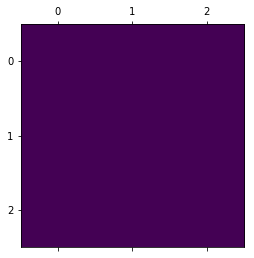

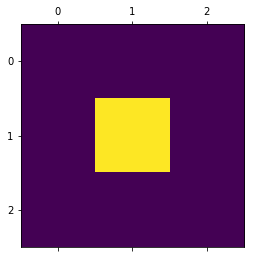

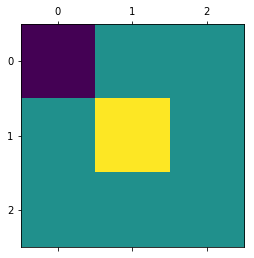

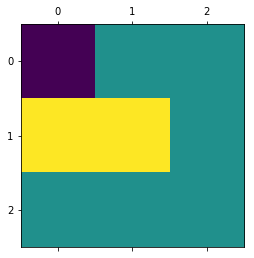

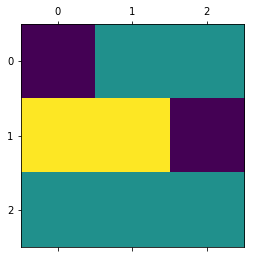

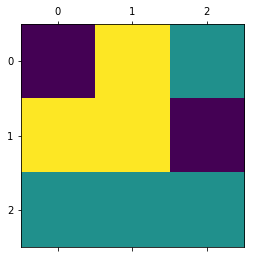

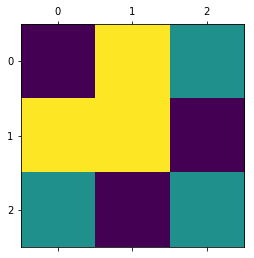

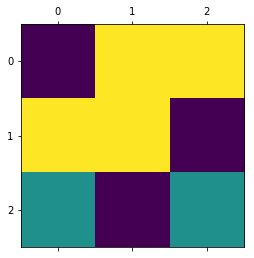

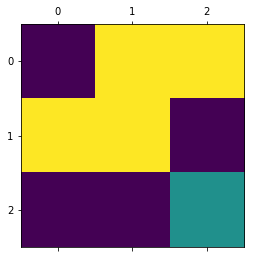

In [54]:
%%time

#%lprun -f MCTSPlayer._do_search 
res = mcts_play_self(ttt, ttt_evaluator, 10000)
for s, _, _, _ in res:
    plt.matshow(s.reshape(3, 3))

In [56]:
example_search_size = 20

class Model(Generic[State]):
    def __init__(self, game: Game[State]):
        self.game = game
    
    PARAMS_TRAIN = 0
    PARAMS_BEST = 1
    
    def eval_states(self, 
                    states: List[State],
                    players: List[Player],
                    using=PARAMS_BEST) -> Tuple[np.ndarray, np.ndarray]:
        probs, values = unzip([self.eval_states(states[i], players[i], using) for i in range(len(players))])
        return np.array(probs), np.array(values)
    
    def eval_state(self, state: State, player: Player, using=PARAMS_BEST) -> Tuple[np.ndarray, np.ndarray]:
        a, v = self.eval_states([state], [player], using)
        return a[0], v[0]
    
    def train(self, batch_size=64, num_iters=1000):
        pass
    
    def add_data(self, 
                 states: List[State], 
                 probs: List[np.ndarray],
                 rewards: List[float],
                 players: List[int]):
        pass

class ExpertIterationTrainer(Generic[State]):
    def __init__(self,
                 model: Model[State],
                 num_iterations: int,
                 iteration_size: int = 100,
                 search_size: int = 100):
        self.model = model
        self.game = self.model.game
        self.num_iterations = num_iterations
        self.iteration_size = iteration_size
        self.search_size = search_size
              
    def train_player(self):
        evaluator = EvaluatorFromFn(lambda s, p: self.model.eval_state(s, p))
        example_games = [mcts_play_self(self.game, evaluator, example_search_size)]
        
        for i in range(1, self.num_iterations + 1):
            example_games.append(mcts_play_self(self.game, evaluator, example_search_size))
            new_probs = [self.model.eval_state(res[0], res[3]) for res in example_games[-1]]
            example_probs = [new_probs]
            
            states, probs, rewards, players = self.play_games()
                
            self.model.add_data(states, probs, rewards, players)
            self.model.train()

            print('finished step %d' % i)

        example_games.append(mcts_play_self(self.game, evaluator, example_search_size))
        new_probs = [self.model.eval_state(res[0], res[3]) for res in example_games[-1]]
        example_probs.append(new_probs)

        return example_games, EvaluatorFromFn(lambda s, p: self.model.eval_state(s, p, using=Model.PARAMS_BEST))
    

    def play_games(self) -> Tuple[List[State], 
                                  List[np.ndarray], 
                                  List[float], 
                                  List[int]]:
        work_q = queue.Queue()
        result_q = queue.Queue()
        go = queue.Queue()
        alive = [self.iteration_size]
        in_q = [0]
        counter_lock = threading.Lock()
        
        def mp_play_self():
            my_q = queue.Queue()

            def eval_state(state: State, p: Player) -> Tuple[np.ndarray, float]:
                with counter_lock:
                    work_q.put(((state, p), my_q))
                    in_q[0] += 1
                    if alive[0] == in_q[0]:
                        go.put(True)
                return my_q.get()

            result = mcts_play_self(self.game, EvaluatorFromFn(eval_state), self.search_size, 1.0)
            with counter_lock:
                alive[0] -= 1
                result_q.put(result)
                if alive[0] == 0:
                    go.put(False)
                elif alive[0] == in_q[0]:
                    go.put(True)
        
        for _ in range(self.iteration_size):
            threading.Thread(target=mp_play_self).start()

        while go.get():
            with counter_lock:
                ret_qs = []
                states = []
                players = []
                for _ in range(in_q[0]):
                    (state, player), ret_q = work_q.get_nowait()
                    ret_qs.append(ret_q)
                    states.append(state)
                    players.append(player)
                in_q[0] = 0
                if len(states) > 0:
                    a, v = self.model.eval_states(states, players, using=Model.PARAMS_BEST)
                    for j, ret_q in enumerate(ret_qs):
                        ret_q.put((a[j], v[j]))
                        
        positions = []
        while not result_q.empty():
            positions += result_q.get_nowait()
        return unzip(positions)

In [60]:
class TTTModel(Model[TTTState]):
    game = TTT()
    
    l2_loss_coeff = 0.01
    hidden_size = 100
    search_size = 100

    graph = tf.Graph()
    with graph.as_default():
        ttt_hw = tf.Variable(tf.truncated_normal([9, hidden_size]))
        ttt_hb = tf.Variable(tf.zeros([hidden_size]))
    
        ttt_aw = tf.Variable(tf.truncated_normal([hidden_size, 9]))
        ttt_ab = tf.Variable(tf.zeros([9]))

        ttt_vw = tf.Variable(tf.truncated_normal([hidden_size, 2]))
        ttt_vb = tf.Variable(tf.zeros([2]))

        weights = [ttt_hw, ttt_hb, ttt_aw, ttt_ab, ttt_vw, ttt_vb]
        saver = tf.train.Saver(weights)

        tf_boards = tf.placeholder(tf.float32, shape=[None, 9])
        hidden = tf.nn.relu(tf.matmul(tf_boards, ttt_hw) + ttt_hb)
        actions = tf.matmul(hidden, ttt_aw) + ttt_ab
        values = tf.tanh(tf.matmul(hidden, ttt_vw) + ttt_vb)

        tf_probs = tf.placeholder(tf.float32, shape=[None, 9])
        tf_zs = tf.placeholder(tf.float32, shape=[None, 2])

        loss = tf.reduce_mean(tf.square(tf_zs - values))
        loss = loss + tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_probs, logits=actions))
        for w in weights:
            loss = loss + l2_loss_coeff * tf.nn.l2_loss(w)

        optimizer = tf.train.AdamOptimizer().minimize(loss)
        
    chkpnt_folder = os.path.join('.', 'checkpoints')
    if not os.path.exists(chkpnt_folder):
        os.makedirs(chkpnt_folder)
    chkpnt_file = os.path.join(chkpnt_folder, 'ttt') 
            
       
    def __init__(self):
        super().__init__(self.game)
        
        self.states = np.empty((0, 9))
        self.probs = np.empty((0, 9))
        self.rewards = np.empty((0, 2))
        self.players = np.empty((0,), dtype=np.int)
        self.cutoffs = []
            
        self.best_evaluator = EvaluatorFromFn(lambda s, p: self.eval_state(s, p, using=Model.PARAMS_BEST))
        self.train_evaluator = EvaluatorFromFn(lambda s, p: self.eval_state(s, p, using=Model.PARAMS_TRAIN))
        
        self.train_step = 0
        self.train_sess = None
        self.best_sess = None
        self.best_chkpnt = None
        
    def __enter__(self):
        self.train_sess = tf.Session(graph=self.graph)
        self.best_sess = tf.Session(graph=self.graph)
        self.train_sess.__enter__()
        self.best_sess.__enter__()
        
        self.train_sess.run(tf.global_variables_initializer())
        self.best_chkpnt = self.saver.save(self.train_sess, self.chkpnt_file, 0)
        self.saver.restore(self.best_sess, self.best_chkpnt)
  
        return self
        
    def __exit__(self, tp, val, traceback):
        self.best_sess.__exit__(tp, val, traceback)
        self.train_sess.__exit__(tp, val, traceback)
        
    def eval_states(self, 
                    states: List[TTTState],
                    players: List[Player],
                    using=Model.PARAMS_BEST) -> Tuple[np.ndarray, np.ndarray]:
        feed = { self.tf_boards: np.array(states) }
        sess = self.best_sess if using == Model.PARAMS_BEST else self.train_sess
        actions, values = sess.run([self.actions, self.values], feed_dict=feed)
        for i in range(actions.shape[0]):
            action = actions[i]
            poss_actions = self.game.valid_actions(states[i], players[i])
            action[~poss_actions] = 0.0
            action[poss_actions] = softmax(action[poss_actions])

        return (actions, values)
    
    def eval_state(self, state: State, player: Player, using=Model.PARAMS_BEST) -> Tuple[np.ndarray, float]:
        a, v = self.eval_states([state], [player], using)
        return a[0], v[0]
    
    def train(self, batch_size=64, num_iters=1000):
        self.train_step += 1
        
        for i in range(1000):
            select = np.random.choice(np.arange(len(self.states)), 64)

            feed = {
                self.tf_boards: self.states[select],
                self.tf_probs: self.probs[select],
                self.tf_zs: self.rewards[select]
            }
            
            self.train_sess.run(self.optimizer, feed_dict=feed)
                
        if self.train_is_better():
            self.best_chkpnt = self.saver.save(self.train_sess, self.chkpnt_file, self.train_step)
            self.saver.restore(self.best_sess, self.best_chkpnt)
        else:
            self.saver.restore(self.train_sess, self.best_chkpnt)

    def train_is_better(self):
        tot_games = 10
        reward = 0
        best_alg = MCTSAlgorithm(self.game, self.best_evaluator, self.search_size)
        train_alg = MCTSAlgorithm(self.game, self.train_evaluator, self.search_size)
        for i in range(tot_games):
            reward += rewards_from_result(play_game(self.game, [({0}, best_alg), ({1}, train_alg)])[1])[1]
            reward += rewards_from_result(play_game(self.game, [({0}, train_alg), ({1}, best_alg)])[1])[0]
        
        avg_reward = reward / (2 * tot_games)
        print(avg_reward)
        return avg_reward > 0.1
            
    
    def add_data(self, 
                 states: List[TTTState], 
                 probs: List[np.ndarray],
                 rewards: List[float],
                 players: List[int]):
        start_i = 0
        if len(self.cutoffs) > 3:
            start_i = self.cutoffs[0]
            self.cutoffs = self.cutoffs[1:]
        self.states = np.concatenate([self.states[start_i:], states])
        self.probs = np.concatenate([self.probs[start_i:], probs])
        self.rewards = np.concatenate([self.rewards[start_i:], rewards])
        self.players = np.concatenate([self.players[start_i:], players])
        self.cutoffs.append(len(players))

INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-0
-0.4
INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-0
finished step 1
-0.5
INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-0
finished step 2
0.4
INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-3
finished step 3
-0.2
INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-3
finished step 4
-0.9
INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-3
finished step 5
play against computer? (y/n)y
 | | 
-----
 | | 
-----
 | | 
x' turn
What is your move? 1 1
x| | 
-----
 |o| 
-----
 | | 
x' turn
What is your move? 1 2
x|x| 
-----
 |o| 
-----
 |o| 
x' turn
What is your move? 1 3
play against computer? (y/n)1 1
(array([ 0.05574251,  0.63655299,  0.04519653,  0.05275496,  0.08648236,
        0.03038999,  0.03488727,  0.02751056,  0.03048282], dtype=float32), array([ 0.0612479 , -0.01841386], dtype=float32))


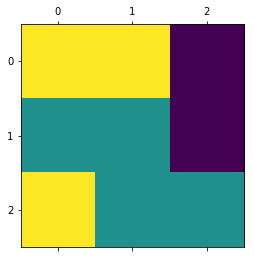

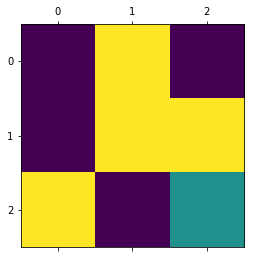

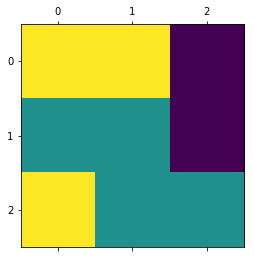

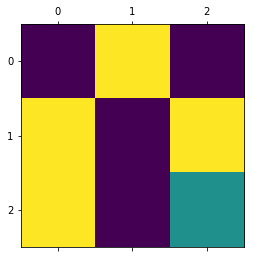

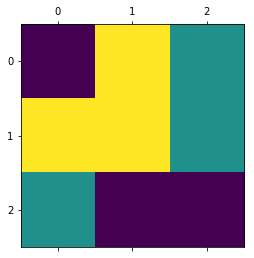

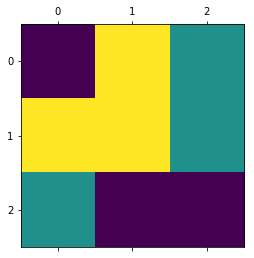

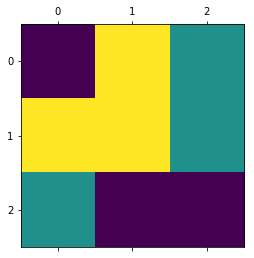

In [61]:
with TTTModel() as model:
    trainer = ExpertIterationTrainer(model, 5)
    #%lprun -f TTTModel.train 
    examples, evaluator = trainer.train_player()
    while input('play against computer? (y/n)') == 'y':
        play_game(ttt, [({0}, MCTSAlgorithm(ttt,  evaluator, 10)), ({1}, UserAlgorithm(ttt))])
    print(evaluator.eval_state(*ttt.gen_root()))

for g in examples[::1]:
    plt.matshow(g[-1][0].reshape(3, 3))